# Before You Start

The current set of notebooks are under constant development.

## Update Tutorial Repository

If you have previously cloned the tutorial repository, you may need to get the latest versions of the notebooks.

First check the status of your repository:
```
cd hls4ml-tutorial
make clean
git status 
```

You may have some _modified_ notebooks. For example:

```
# On branch csee-e6868-spring2021
# Changes not staged for commit:
#   (use "git add <file>..." to update what will be committed)
#   (use "git checkout -- <file>..." to discard changes in working directory)
#
#	modified:   part1_getting_started.ipynb
#	modified:   part2_advanced_config.ipynb
#	modified:   part2b_advanced_config.ipynb
#
no changes added to commit (use "git add" and/or "git commit -a")
```

You can make a copy of those modified notebooks if you had significat changes, otherwise the easiest thing to do is to discard those changes.

**ATTENTION** You will loose your local changes!

```
git checkout *.ipynb
```

At this point, you can update you copy of the repository:
```
git pull
```


## Update Conda Environment

It is likely that you are running this notebook in the Conda environment `hls4ml-tutorial-cu`.

If you did not do that yet, you should update the `hls4ml` packages with the latest changes in the working branch.

```
conda activate hls4ml-tutorial-cu
pip uninstall hls4ml
pip install git+https://github.com/GiuseppeDiGuglielmo/hls4ml.git@gdg/cosmetics#egg=hls4ml[profiling]
```

You may need to restart the Jupyter notebook.

# Part 1: Getting started

## Model Training

<img src="images/training.png" style="width:640px;" />

### Setup

Import packages from [TensorFlow](https://www.tensorflow.org), [scikit-learn](https://scikit-learn.org), and [NumPy](https://numpy.org).

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import numpy as np

Use a [magic function](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) to include matplotlib graphs in the notebook.

In [2]:
%matplotlib inline

Force a deterministic behaviour with a constant seed. In TensorFlow, `tf.random.set_seed` sets a global-random seed; you can also specify operation-level seeds. More [details](https://www.tensorflow.org/api_docs/python/tf/random/set_seed).

In [3]:
seed = 0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

Specify where the to find the executable of Xilinx Vivado HLS. The path on the Columbia servers is `/opt/Xilinx/Vivado/2019.2/bin`, but you can change it if you have a local installation of this notebook.

In [4]:
import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


### Fetch the jet tagging dataset from OpenML

The [jet tagging dataset](https://www.openml.org/d/42468) is publicly available on [OpenML](https://www.openml.org).

In [5]:
data = fetch_openml('hls4ml_lhc_jets_hlf')
X, y = data['data'], data['target']

Let's print some information about the dataset (e.g. feature names and the dataset shape).

In [6]:
print('-----------------------------------')
print('Feature names')
print(data['feature_names'])
print('-----------------------------------')
print('Shape of the data and label (target) arrays')
print(X.shape, y.shape)
print('-----------------------------------')

-----------------------------------
Feature names
['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
-----------------------------------
Shape of the data and label (target) arrays
(830000, 16) (830000,)
-----------------------------------


Let's print some data and labels.

In [7]:
import pandas as pd
print('-----------------------------------')
print('\nFirst five samples in the data set')
display(pd.DataFrame(data=X[:5]))

print('\nFirst five labels (targets) in the data set')
display(pd.DataFrame(data=y[:5]))
print('-----------------------------------')

-----------------------------------

First five samples in the data set


,zlogz,c1_b0_mmdt,c1_b1_mmdt,c1_b2_mmdt,c2_b1_mmdt,c2_b2_mmdt,d2_b1_mmdt,d2_b2_mmdt,d2_a1_b1_mmdt,d2_a1_b2_mmdt,m2_b1_mmdt,m2_b2_mmdt,n2_b1_mmdt,n2_b2_mmdt,mass_mmdt,multiplicity
0,-2.935125,0.383155,0.005126,0.000084,0.009070,0.000179,1.769445,2.123898,1.769445,0.308185,0.135687,0.083278,0.412136,0.299058,8.926882,75.0
1,-1.927335,0.270699,0.001585,0.000011,0.003232,0.000029,2.038834,2.563099,2.038834,0.211886,0.063729,0.036310,0.310217,0.226661,3.886512,31.0
2,-3.112147,0.458171,0.097914,0.028588,0.124278,0.038487,1.269254,1.346238,1.269254,0.246488,0.115636,0.079094,0.357559,0.289220,162.144669,61.0
3,-2.666515,0.437068,0.049122,0.007978,0.047477,0.004802,0.966505,0.601864,0.966505,0.160756,0.082196,0.033311,0.238871,0.094516,91.258934,39.0
4,-2.484843,0.428981,0.041786,0.006110,0.023066,0.001123,0.552002,0.183821,0.552002,0.084338,0.048006,0.014450,0.141906,0.036665,79.725777,35.0



First five labels (targets) in the data set


,class
0,g
1,w
2,t
3,z
4,w


-----------------------------------


We can visualize the data with [boxplots](https://en.wikipedia.org/wiki/Box_plot) and notice that the distribution of some of the features is larger than others. You can also plot the outliers with `showfliers=True`.

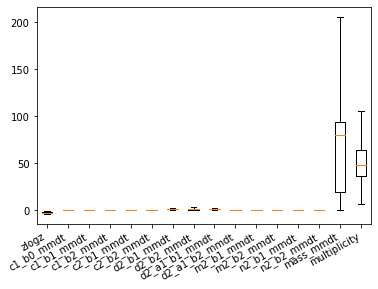

In [8]:
plt.boxplot(X, showfliers=False)
_ = plt.xticks(np.arange(1, X.shape[1] + 1), data['feature_names'], rotation=30, ha="right")

### Preprocessing

As you saw above, the `y` target is an array of strings, e.g. \['g', 'w',...\] etc.
We need to make this a _One Hot encoding_ for the training phase.

In [9]:
print('-----------------------------------')
print(y[:5]) # Target labels
print('-----------------------------------')
le = LabelEncoder()
y = le.fit_transform(y) # Encode target labels with values
print(y[:5])
print('-----------------------------------')
y = to_categorical(y, 5) # Convert those values to one-hot encoding
print(y[:5])
print('-----------------------------------')

-----------------------------------
0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, object): ['g', 'q', 'w', 'z', 't']
-----------------------------------
[0 3 2 4 3]
-----------------------------------
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]
-----------------------------------


Split the dataset into training (80% of the samples) and test (20%) sets.

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('-----------------------------------')
print('*** Shape of the splitted arrays ***')
print(X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape)
print('-----------------------------------')

-----------------------------------
*** Shape of the splitted arrays ***
(664000, 16) (166000, 16) (664000, 5) (166000, 5)
-----------------------------------


As we have done before, let's plot the boxplots for the training-validation set only.

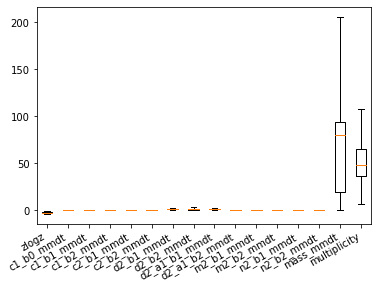

In [11]:
plt.boxplot(X_train_val, showfliers=False)
_ = plt.xticks(np.arange(1, X_train_val.shape[1] + 1), data['feature_names'], rotation=30, ha="right")

Preprocess the data `X` with the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
```
Zi = (Xi - u) / s
```
where `u` is the mean of the training samples and `s` is the standard deviation of the training samples. The resulting will have a mean value (closer to) 0 and standard deviation of (closer to) 1.

In [12]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

Finally let's plot the boxplots for the training-validation set after the standard scaling.

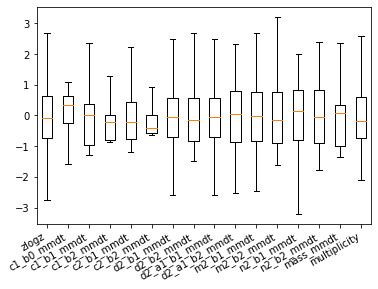

In [13]:
plt.boxplot(X_train_val, showfliers=False)
_ = plt.xticks(np.arange(1, X_train_val.shape[1] + 1), data['feature_names'], rotation=30, ha="right")

Save NumPy arrays to files for this notebooks and the next ones (so you do not have to run it again).

In [14]:
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', le.classes_)

### Construct the model

Import additional [Keras](https://keras.io) packages. Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow. It was developed with a focus on enabling fast experimentation.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks

We create a simple _multi-layer perceptron (MLP)_ model. An MLP consists of at least three dense layers of nodes alternating with activation functions.

- We use the [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model) that is essentially a stack of layers, where each layer has exactly one input tensor and one output tensor. See also the [Functional API](https://www.tensorflow.org/guide/keras/functional).
- We use _3_ hidden layers with _64_, then _32_, then _32_ neurons. See a plot of the model in the next few cell.
- Each layer will use ReLU activation.
- Add an output layer with _5_ neurons (one for each class), then finish with Softmax activation.
- [Initializers](https://keras.io/api/layers/initializers) define the way to set the initial random weights of Keras layers. In this case, we choose [LecunUniform](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/LecunUniform).
- [Regularizers](https://keras.io/api/layers/regularizers) help to get models that generalize to new, unseen data (see the [overfitting problem](https://en.wikipedia.org/wiki/Overfitting)); the regularizes allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes. In this case, we choose [L1 regularization](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L1) that producer _sparse models_, i.e. model where unnecessary features are set to zero, thus do not contribute to the model predictive power.

In [16]:
model = Sequential()
model.add(Dense(64, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

Plot model. See this post on [How do you visualize neural network architectures?
](https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures)

The question mark `?` or `None` is for the batch size that is unknown to the model.

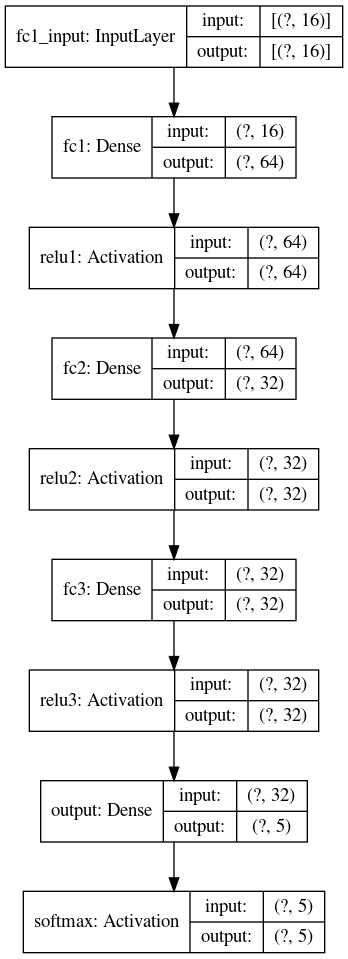

In [17]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Train the model
If this is the first time you run the notebook `train = True`; if you've restarted the notebook kernel after training once, set `train = False` to load the trained model from file.

In [18]:
train = True

Once the model is created, you can config the model with losses and metrics with `model.compile()`, train the model with `model.fit()`.
- We use [Adam optimizer](https://keras.io/api/optimizers/adam) with [categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) loss.
- We use [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback) that are utilities executed during training at some given stages of the training procedure. Callbacks can help you prevent overfitting, visualize training progress, debug your code, save checkpoints, generate logs etc. The callbacks will decay the learning rate and save the model into a directory `model_1`.
- The model isn't very complex, so this should just take a few minutes even on the CPU.

In [19]:
if train:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model_1')
    model.fit(X_train_val, y_train_val, batch_size=1024,
              epochs=30, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
else:
    from tensorflow.keras.models import load_model
    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/30
  1/487 [..............................] - ETA: 0s - loss: 1.6388 - accuracy: 0.3027WARNING:tensorflow:From /home/giuseppe/miniconda3/envs/hls4ml-tutorial-cu/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
480/487 [============================>.] - ETA: 0s - loss: 1.3319 - accuracy: 0.5145
***callbacks***
saving losses to model_1/losses.log

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.12515, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last.h5

Epoch 00001: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 4ms/step - loss: 1.3290 - accurac

474/487 [============================>.] - ETA: 0s - loss: 0.8020 - accuracy: 0.7398
***callbacks***
saving losses to model_1/losses.log

Epoch 00012: val_loss improved from 0.80989 to 0.80381, saving model to model_1/KERAS_check_best_model.h5

Epoch 00012: val_loss improved from 0.80989 to 0.80381, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last.h5

Epoch 00012: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.8022 - accuracy: 0.7399 - val_loss: 0.8038 - val_accuracy: 0.7401
Epoch 13/30
478/487 [============================>.] - ETA: 0s - loss: 0.7969 - accuracy: 0.7412
***callbacks***
saving losses to model_1/losses.log

Epoch 00013: val_loss improved from 0.80381 to 0.79870, saving model to model_1/KERAS_check_best_model.h5

Epoch 00013: val_loss improved from 0.80381 to 0.79870, saving model to model_1/KERAS_check_bes

Epoch 25/30
482/487 [============================>.] - ETA: 0s - loss: 0.7635 - accuracy: 0.7505
***callbacks***
saving losses to model_1/losses.log

Epoch 00025: val_loss improved from 0.76954 to 0.76790, saving model to model_1/KERAS_check_best_model.h5

Epoch 00025: val_loss improved from 0.76954 to 0.76790, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last.h5

Epoch 00025: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

487/487 [==============================] - 2s 3ms/step - loss: 0.7635 - accuracy: 0.7505 - val_loss: 0.7679 - val_accuracy: 0.7493
Epoch 26/30
487/487 [==============================] - ETA: 0s - loss: 0.7619 - accuracy: 0.7510
***callbacks***
saving losses to model_1/losses.log

Epoch 00026: val_loss improved from 0.76790 to 0.76632, saving model to model_1/KERAS_check_best_model.h5

Epoch 00026: val_loss improved from 0.76790 to 0.76632, saving model to model_1/KER

### Check performance
Check the accuracy.

In [20]:
y_keras = model.predict(X_test)

from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("Keras Accuracy:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print('-----------------------------------')

-----------------------------------
Keras Accuracy:  0.7503072289156627
-----------------------------------


Accuracy may be _not_ the best or only metric that you should consider when you are dealing with a classification problem, expecially with a skewed dataset.

A [confusion matrix]() is the a tool that you can use to get a better understanding of how a classifier perform.

<!--![confusion_matrix](images/confusion_matrix.png "Confusion Matrix")-->
<img src="images/confusion_matrix.png" style="width:600px; float:left;">

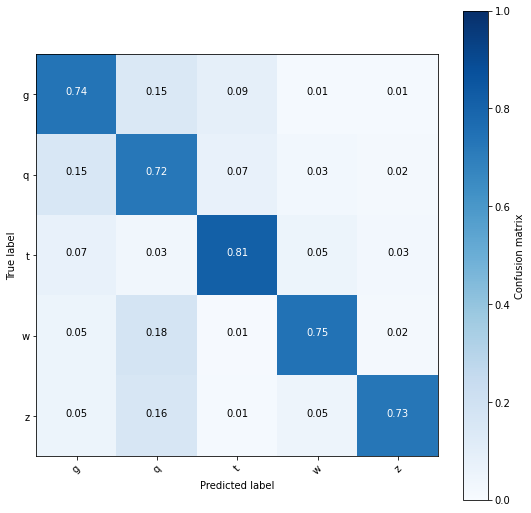

In [21]:
import plotting # Import local package plotting.py
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_keras, axis=1))
plt.figure(figsize=(9,9))
_ = plotting.plot_confusion_matrix(cm, le.classes_)

Another tool that you can use is the [ROC curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

A ROC curve (typically) features true positive rate (TPR) on the vertical axis, and false positive rate (FPR) on the horizzontal axis. The top left corner of the plot is the _ideal_ point - a FPR rate of zero, and a TPR of one. This also mean that a larger area under the curve (AUC) is usually better

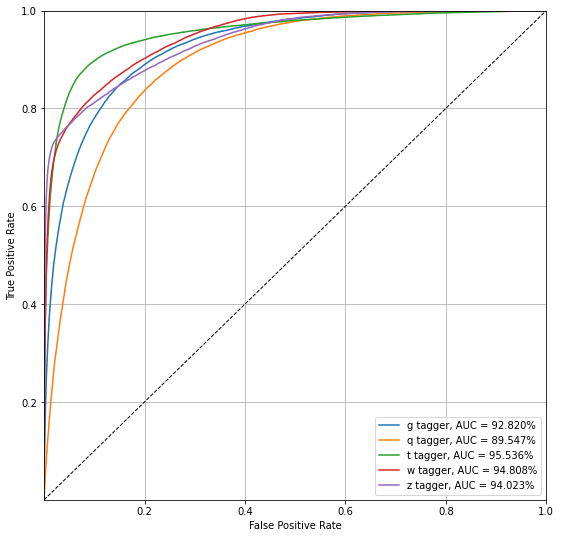

In [22]:
plt.figure(figsize=(9,9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, le.classes_)

## Convert the model to FPGA firmware with hls4ml

<img src="images/convert.png" style="width:600px">

Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
- First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types. 
- Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.

hls4ml comes with a [Python API](https://fastmachinelearning.org/hls4ml) so all of the next steps will be run through the notebook and that includes HLS.

In [23]:
# Let's import hls4ml package!
import hls4ml

### Create an hls4ml configuration & model

hls4ml is controlled through an _hls4ml configuration dictionary_. In this example, we'll use the most simple variation (`granularity='model'`), later exercises will look at more advanced configuration.

In [24]:
# Generate a hls4ml configuration dictionary from the Keras model
config = hls4ml.utils.config_from_keras_model(model, granularity='model')

print('-----------------------------------')
# Show the generated configuration dictionary for hls4ml
plotting.print_dict(config)
print('-----------------------------------')

-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
-----------------------------------


Let's create an HLS model from the Keras model and hls4ml configuration dictionary. Please just notice that, in these notebooks, we plan to target (`fpga_part`) three different boards equipped with Xilinx SoC chips: a [ZCU106](https://www.xilinx.com/products/boards-and-kits/zcu106.html), an [Ultra96](http://zedboard.org/product/ultra96-v2-development-board), [Pyqn-Z1](https://reference.digilentinc.com/reference/programmable-logic/pynq-z1), and an even _smaller_ [MiniZed](http://zedboard.org/product/minized).

In [25]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model_1/hls4ml_prj',
                                                       #fpga_part='xczu7ev-ffvc1156-2-e') # ZCU106
                                                       fpga_part='xczu3eg-sbva484-1-e') # Ultra96
                                                       #fpga_part='xc7z020clg400-1') # Pynq-Z1
                                                       #fpga_part='xc7z007sclg225-1') # MiniZed

Let's visualise the HLS model that we created. The model architecture is shown annotated with the layer shapes and [data types](https://github.com/Xilinx/HLS_arbitrary_Precision_Types). Please note that we are converting the trained model from a floating-point implementation to a fixed-point implementation. _Post-training quantization_ is a conversion technique that can reduce resource requriments and latency of the final hardware accelerator, with little degradation in model accuracy.

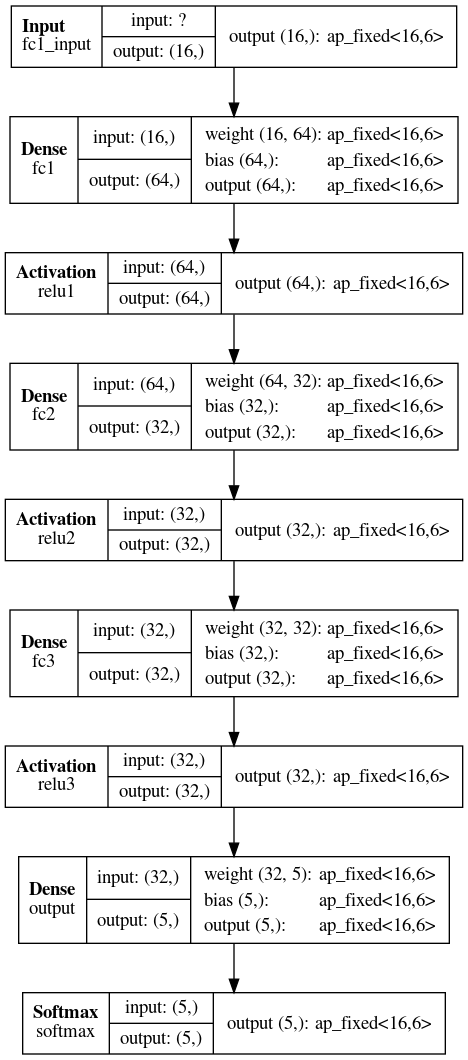

In [26]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Compile & Predict

Because of the quantization, now we need to check that the HLS-model performance is still good. We first compile the `hls_model`.

In [27]:
%%time
hls_model.compile()

CPU times: user 140 ms, sys: 42.8 ms, total: 183 ms
Wall time: 5.88 s


Then we use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation **on the CPU**.

In [28]:
%%time
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
# this an alternative to np.ascontiguousarray()
#X_test = X_test.copy(order='C')
#y_hls = hls_model.predict(X_test)

CPU times: user 24.3 s, sys: 0 ns, total: 24.3 s
Wall time: 24.3 s


### Compare Performance
That was easy! Now let's see how the performance compares to Keras:

-----------------------------------
Keras  Accuracy: 0.7503072289156627
hls4ml Accuracy: 0.7503795180722892
-----------------------------------


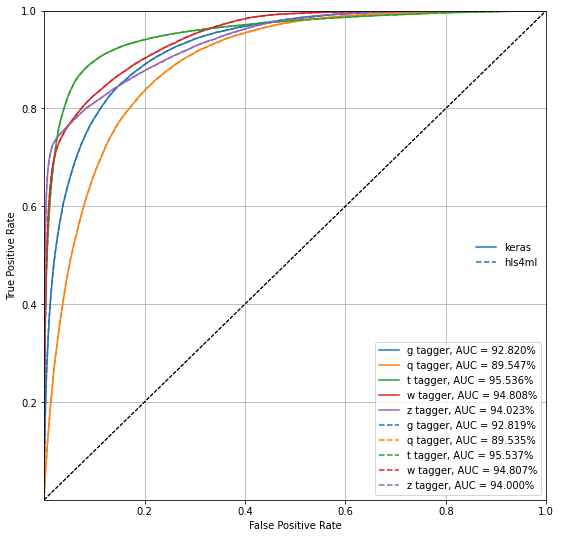

In [29]:
print('-----------------------------------')
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print('-----------------------------------')

# Enable logarithmic scale on TPR and FPR axes 
logscale_tpr = False # Y axis
logscale_fpr = False # X axis

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.plotMultiClassRoc(y_test, y_keras, le.classes_, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.plotMultiClassRoc(y_test, y_hls, le.classes_, logscale_tpr=logscale_tpr, logscale_fpr=logscale_fpr, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='center right', frameon=False)
_ = ax.add_artist(leg)

The AUC results for the Keras and hls4ml implementation are really close - up to the second decimal point. You can notice the difference on ROC curves if you apply logaritmic scale on the FPR axis (`logscale_fpr=True`).

### Synthesize
Now we'll actually use Vivado HLS to synthesize the model (_C-Synthesis_). We can run the build using a method of our `hls_model` object.

After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

In [30]:
%%time
hls_results = hls_model.build(csim=False)

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 12min


**This takes approx. 15 minutes on Columbia servers.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

<img src='images/terminal.png'>

### Check the results

You can print the HLS results from the synthesis at the previous step.

In [31]:
print('-----------------------------------')
#print(hls_results) # Print hashmap
print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {} (Aval. {})".format(hls_results['BRAM_18K'], hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {} (Aval. {})".format(hls_results['DSP48E'], hls_results['AvailableDSP48E']))
print("FF:                     {} (Aval. {})".format(hls_results['FF'], hls_results['AvailableFF']))
print("LUT:                    {} (Aval. {})".format(hls_results['LUT'], hls_results['AvailableLUT']))
print("URAM:                   {} (Aval. {})".format(hls_results['URAM'], hls_results['AvailableURAM']))
print('-----------------------------------')

-----------------------------------
Estimated Clock Period: 4.198 ns
Best/Worst Latency:     13 / 13
Interval Min/Max:       1 / 1
BRAM_18K:               4 (Aval. 432)
DSP48E:                 3915 (Aval. 360)
FF:                     49449 (Aval. 141120)
LUT:                    88289 (Aval. 70560)
URAM:                   0 (Aval. 0)
-----------------------------------


In [32]:
print(hls_results)

{'EstimatedClockPeriod': '4.198', 'BestLatency': '13', 'WorstLatency': '13', 'IntervalMin': '1', 'IntervalMax': '1', 'BRAM_18K': '4', 'DSP48E': '3915', 'FF': '49449', 'LUT': '88289', 'URAM': '0', 'AvailableBRAM_18K': '432', 'AvailableDSP48E': '360', 'AvailableFF': '141120', 'AvailableLUT': '70560', 'AvailableURAM': '0'}


You can also view the entire reports generated by Vivado HLS. Pay attention to the _Latency_ and the _Utilization Estimates_ sections.

In [33]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')

Found 1 solution(s) in model_1/hls4ml_prj//myproject_prj.
Reports for solution "solution1":

C simulation report not found.
SYNTHESIS REPORT:
== Vivado HLS Report for 'myproject'
* Date:           Wed Feb 24 16:46:21 2021

* Version:        2019.2 (Build 2704478 on Wed Nov 06 22:10:23 MST 2019)
* Project:        myproject_prj
* Solution:       solution1
* Product family: zynquplus
* Target device:  xczu3eg-sbva484-1-e


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
    |  Clock |  Target | Estimated| Uncertainty|
    +--------+---------+----------+------------+
    |ap_clk  | 5.00 ns | 4.198 ns |   0.62 ns  |
    +--------+---------+----------+------------+

+ Latency: 
    * Summary: 
    +---------+---------+-----------+-----------+-----+-----+----------+
    |  Latency (cycles) |   Latency (absolute)  |  Interval | Pipeline |
    |   min   |   max   |    min    |    max    | min | max |   Type   |
    +---------+---------+------

### Under the Hood

The `hls_model` and in particular all of the the hls4ml-generated files are in the `model_1/hls4ml_prj` directory.

In this tutorial we use the [Python API](https://fastmachinelearning.org/hls4ml/autodoc/hls4ml.html) to hls4ml, but the tool comes also with a [command line interface](https://fastmachinelearning.org/hls4ml/command.html)

## Conclusions

With the current hls4ml configurations, the resource usage that HLS _estimates_ for the current design is greater than the available resources on each of the boards ([ZCU106](https://www.xilinx.com/products/boards-and-kits/zcu106.html), [Ultra96](http://zedboard.org/product/ultra96-v2-development-board), [Pynq-Z1](https://reference.digilentinc.com/reference/programmable-logic/pynq-z1), and [MiniZed](http://zedboard.org/product/minized)).

In the next notebooks, we will learn how to reduce the hardware-resource usage without affecting the model accuracy.

<img src="images/boards.png" style="width:640pt;" />

Here we summarize the expected latency and resource costs for each of these boards from the previous synthesis runs.

```
+-----------------------------------------------------------+
|                        ZCU106                             |
+-----------------+---------+-------+--------+--------+-----+
|       Name      | BRAM_18K| DSP48E|   FF   |   LUT  | URAM|
+-----------------+---------+-------+--------+--------+-----+ +-----+-----+-----+-----+----------+
|Total            |        4|   3911|   26921|   88404|    0| |  Latency  |  Interval | Pipeline |
+-----------------+---------+-------+--------+--------+-----+ | min | max | min | max |   Type   |
|Available        |      624|   1728|  460800|  230400|   96| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+--------+-----+ |    9|    9|    1|    1| function |
|Utilization (%)  |    ~0   |    226|       5|      38|    0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+--------+-----+

+-----------------------------------------------------------+
|                        Ultra96                            |
+-----------------+---------+-------+--------+-------+------+
|       Name      | BRAM_18K| DSP48E|   FF   |   LUT |  URAM|
+-----------------+---------+-------+--------+-------+------+ +-----+-----+-----+-----+----------+
|Total            |        4|   3911|   49742|  88564|     0| |  Latency  |  Interval | Pipeline |
+-----------------+---------+-------+--------+-------+------+ | min | max | min | max |   Type   |
|Available        |      432|    360|  141120|  70560|     0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+------+ |   14|   14|    1|    1| function |
|Utilization (%)  |    ~0   |   1086|      35|    125|     0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+------+

+----------------------------------------------------------+
|                        Pynq-Z1                           |
+-----------------+---------+-------+--------+-------+-----+ +-----+-----+-----+-----+----------+
|       Name      | BRAM_18K| DSP48E|   FF   |  LUT  | URAM| |  Latency  |  Interval | Pipeline |
+-----------------+---------+-------+--------+-------+-----+ | min | max | min | max |   Type   |
|Total            |        4|   3911|  270258|  90772|    0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+-----+ |   52|   52|    1|    1| function |
|Available        |      280|    220|  106400|  53200|    0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+-----+
|Utilization (%)  |        1|   1777|     254|    170|    0|
+-----------------+---------+-------+--------+-------+-----+

+----------------------------------------------------------+
|                        MiniZed                           |
+-----------------+---------+-------+--------+-------+-----+ +-----+-----+-----+-----+----------+
|Total            |        4|   3911|  270258|  90772|    0| |  Latency  |  Interval | Pipeline |
+-----------------+---------+-------+--------+-------+-----+ | min | max | min | max |   Type   |
|Available        |      100|     66|   28800|  14400|    0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+-----+ |   52|   52|    1|    1| function |
|Utilization (%)  |        4|   5925|     938|    630|    0| +-----+-----+-----+-----+----------+
+-----------------+---------+-------+--------+-------+-----+
```

## Exercise
Since `ReuseFactor = 1` we expect each multiplication used in the inference of our neural network to use 1 DSP. Is this what we see? (Note that the Softmax layer should use 5 DSPs, or 1 per class)
Calculate how many multiplications are performed for the inference of this network...
(We'll discuss the outcome)